In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
train_dir = 'archive/chest_xray/train'
test_dir = 'archive/chest_xray/test'

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
test_datagen = ImageDataGenerator(rescale=1./255)



In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enhanced Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,       # Random rotation up to 15 degrees
    width_shift_range=0.1,   # Random horizontal shift
    height_shift_range=0.1,  # Random vertical shift
    shear_range=0.1,         # Shear transformations
    zoom_range=0.1,          # Random zoom
    horizontal_flip=True,    # Random horizontal flips
    fill_mode='nearest'      # How to fill missing pixels
)

# Validation/Test data should NOT be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
import numpy as np
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)  # Should show higher weight for the minority class

Class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


Improved model

In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import class_weight

# Load pre-trained VGG16 without top layers
base_model = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(224, 224, 3))

# Freeze the base model initially
base_model.trainable = False

# Build new model on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)  # Better than Flatten for transfer learning
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

# Compile with lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', 
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall')])

In [5]:
# Phase 1: Train only the new layers
initial_epochs = 5
history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=test_generator,
    class_weight=class_weights
)

# Phase 2: Fine-tune some base layers
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 10
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Continue training
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    initial_epoch=history.epoch[-1] + 1,
    epochs=total_epochs,
    validation_data=test_generator,
    class_weight=class_weights
)

C:\Users\ameen\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1720s 11s/step - accuracy: 0.5868 - loss: 0.6739 - precision: 0.7984 - recall: 0.5835 - val_accuracy: 0.7885 - val_loss: 0.5655 - val_precision: 0.8933 - val_recall: 0.7513
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1687s 10s/step - accuracy: 0.7896 - loss: 0.4968 - precision: 0.9300 - recall: 0.7775 - val_accuracy: 0.7901 - val_loss: 0.5046 - val_precision: 0.9111 - val_recall: 0.7359
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1706s 10s/step - accuracy: 0.8446 - loss: 0.4040 - precision: 0.9633 - recall: 0.8211 - val_accuracy: 0.8221 - val_loss: 0.4461 - val_precision: 0.8864 - val_recall: 0.8205
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1657s 10s/step - accuracy: 0.8551 - loss: 0.3639 - precision: 0.9622 - recall: 0.8390 - val_accuracy: 0.8253 - val_loss: 0.4178 - val_precision: 0.8871 - val_recall: 0.8256
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1636s 10s/step - accuracy: 0.8802 - loss: 0.3109 - precision: 0.9747 - recall: 0.8607 - val_accuracy: 0.8285 - va

In [6]:
# Save with optimizer 
model.save("vgg16_pneumonia_model_w_finetuning.keras") 


In [7]:
from tensorflow.keras.models import load_model
#Uncomment when you need to load model
#model = load_model("vgg16_pneumonia_model_w_finetuning.keras")

# Confirm it's working
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,067,845 (156.66 MB)

 Trainable params: 13,110,785 (50.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

 Optimizer params: 26,221,572 (100.03 MB)

In [9]:
# Evaluate on validation set
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 167s 8s/step - accuracy: 0.9260 - loss: 0.2320
Test Accuracy: 0.94


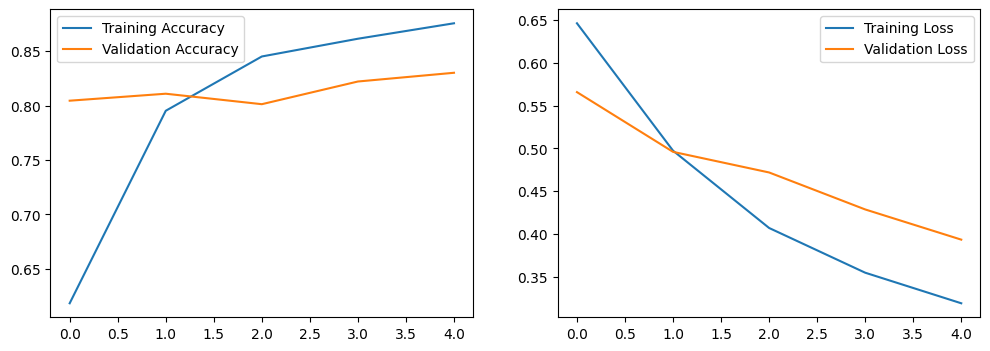

In [10]:
#new graphs
import matplotlib.pyplot as plt

def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.show()

plot_metrics(history)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
test_generator.reset()
pred_probs = model.predict(test_generator)
pred_classes = (pred_probs > 0.5).astype(int).flatten()

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(true_classes, pred_classes, target_names=class_labels))


20/20 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step
              precision    recall  f1-score   support

      NORMAL       0.94      0.89      0.92       234
   PNEUMONIA       0.94      0.97      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.93      0.93       624
weighted avg       0.94      0.94      0.94       624



In [12]:
import numpy as np

# Get predicted probabilities (sigmoid outputs)
test_generator.reset()
y_pred_probs = model.predict(test_generator)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# True labels
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())


20/20 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step


<Figure size 600x600 with 0 Axes>

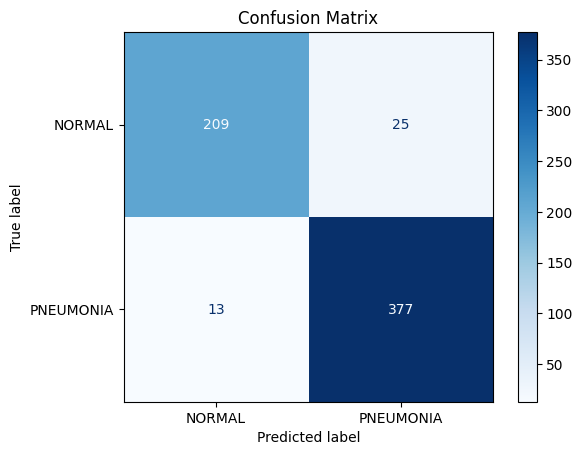

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

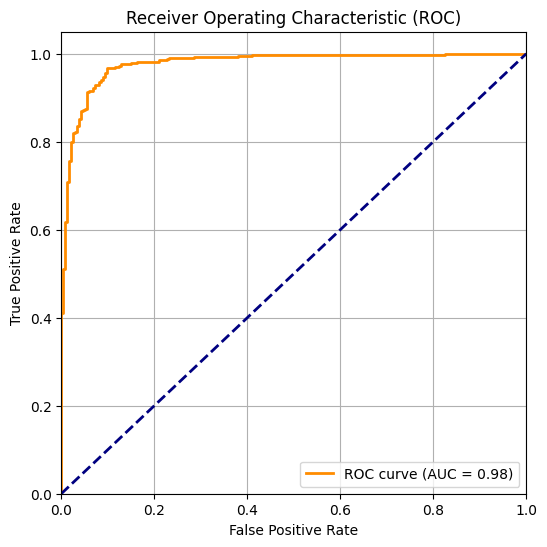

In [14]:
from sklearn.metrics import roc_curve, auc

# Get the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


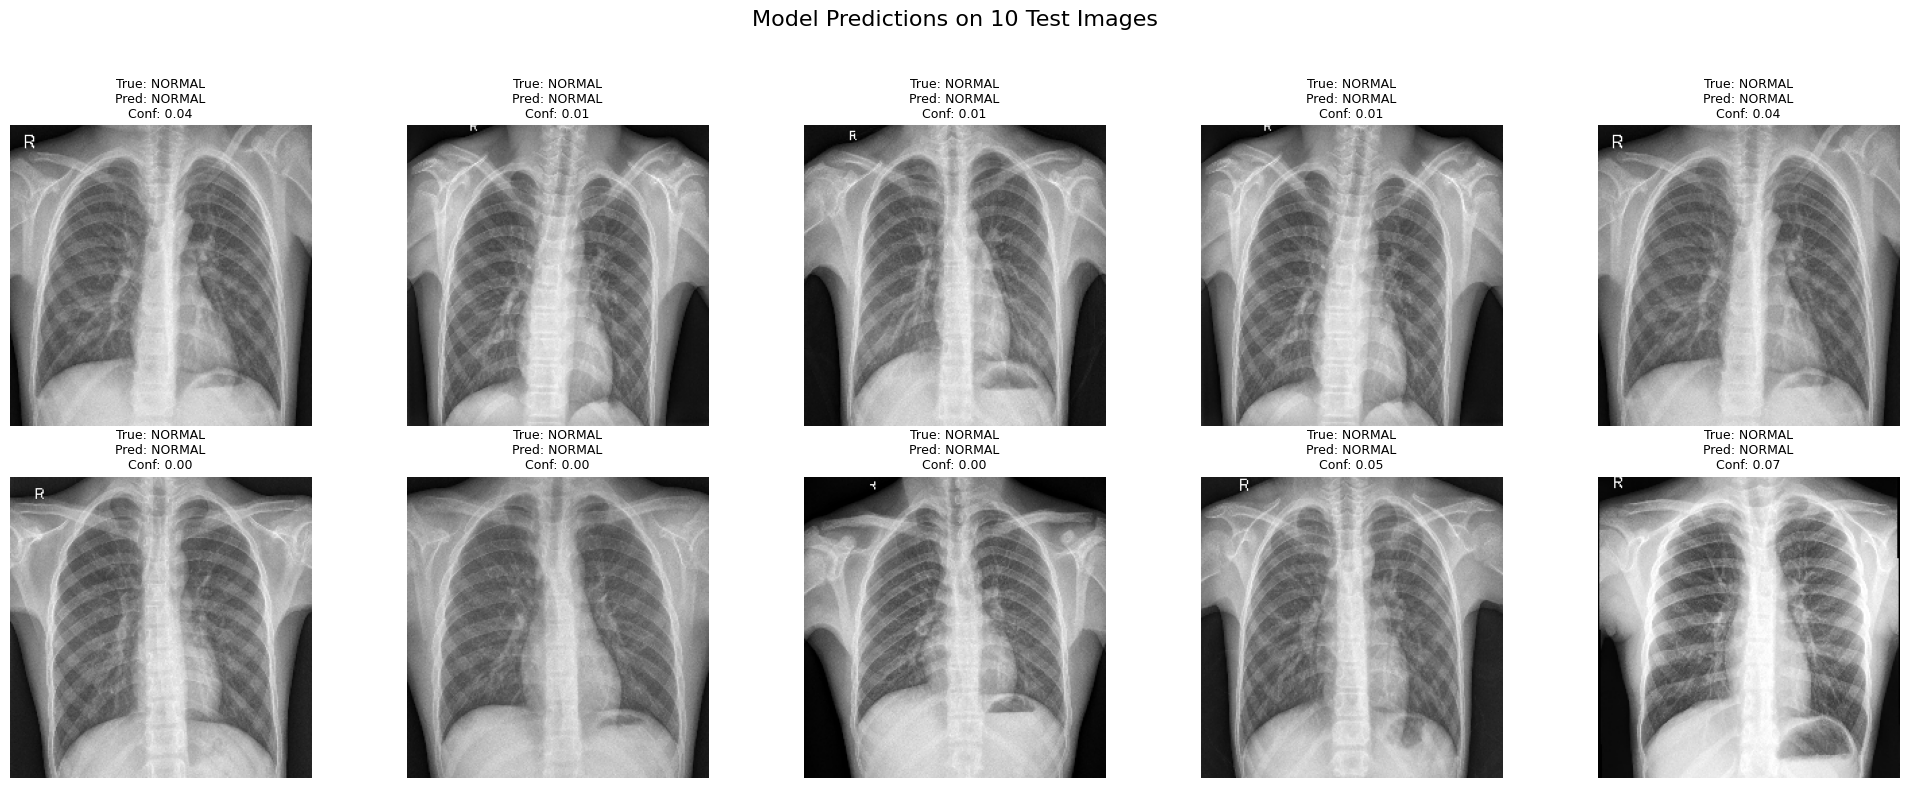

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing import image

class_names = list(test_generator.class_indices.keys())  # ['NORMAL', 'PNEUMONIA']

test_images, test_labels = next(test_generator) 
pred_probs = model.predict(test_images)
pred_classes = (pred_probs > 0.5).astype(int).flatten()

num_images = 10
plt.figure(figsize=(20, 8))

for i in range(num_images):
    idx = random.randint(0, len(test_images) - 1)
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[idx])
    plt.axis('off')
    
    true_label = class_names[int(test_labels[idx])]
    predicted_label = class_names[pred_classes[idx]]
    confidence = pred_probs[idx][0]

    plt.title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}", fontsize=9)

plt.suptitle("Model Predictions on 10 Test Images", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

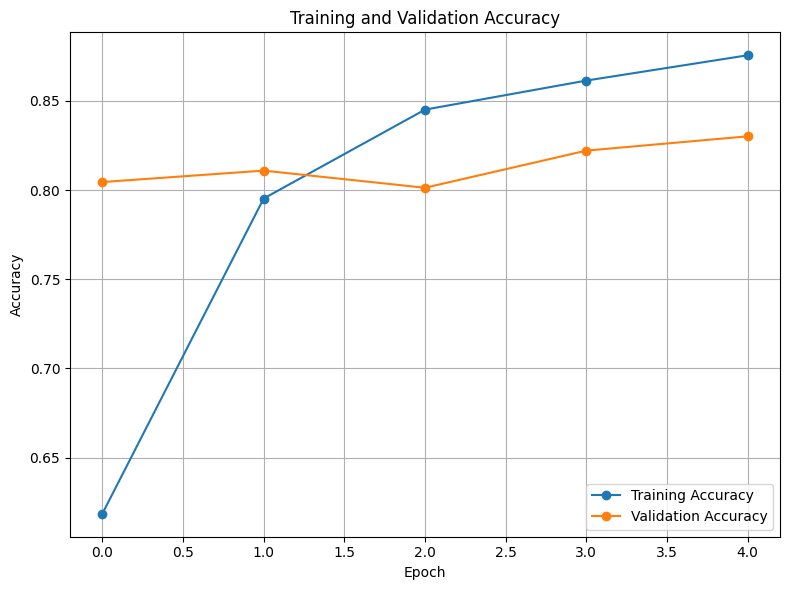

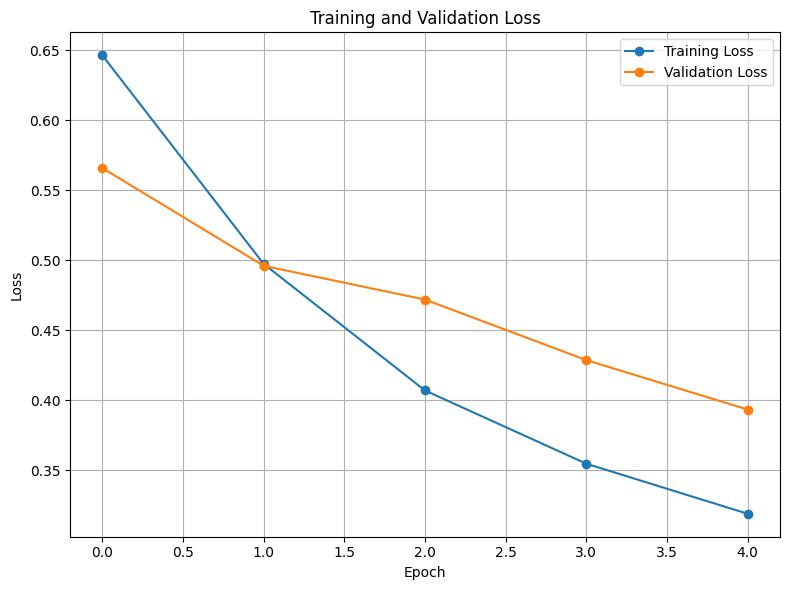

In [16]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
for layer in base_model.layers:
    print(layer.name)

input_layer_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
